# Analysis of complex data for Barnett project 

Use P and B

## Import packages and data

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from indra.databases import uniprot_client
# pip install git+https://github.com/sorgerlab/indra.git

def uniprot_to_hgnc_name(uniprot_id):
    """Get an HGNC ID from a UniProt."""
    return uniprot_client.get_gene_name(uniprot_id)

In [2]:
abundance_df = pd.read_csv('../data/Abundance_Ultra.csv')
hl_df = pd.read_csv('../data/Half_lives_Ultra.csv')

abundance_df = abundance_df.rename(columns={'Unnamed: 0': 'Protein'})
hl_df = hl_df.rename(columns={'Unnamed: 0': 'Protein'})

# Convert hl_df and abundance_df to long format
abundance_long = pd.melt(abundance_df, id_vars=['Protein'], 
                         var_name='Sample', value_name='Abundance')
hl_long = pd.melt(hl_df, id_vars=['Protein'], 
                  var_name='Sample', value_name='Half_life')

# Join
merged_df = pd.merge(abundance_long, hl_long, on=['Protein', 'Sample'],
                     how='outer')

merged_df['Condition'] = merged_df['Sample'].str[0]
merged_df['logIntensity'] = np.log2(merged_df['Abundance'])

merged_df.head()

,Protein,Sample,Abundance,Half_life,Condition,logIntensity
0,A0A087WRI3,B_R-B2_1_5404,NaN,NaN,B,NaN
1,A0A087WRI3,B_R-B3_1_5405,NaN,NaN,B,NaN
2,A0A087WRI3,B_R-B4_1_5406,NaN,NaN,B,NaN
3,A0A087WRI3,B_R-D5_1_5407,NaN,NaN,B,NaN
4,A0A087WRI3,B_R-D6_1_5408,NaN,NaN,B,NaN


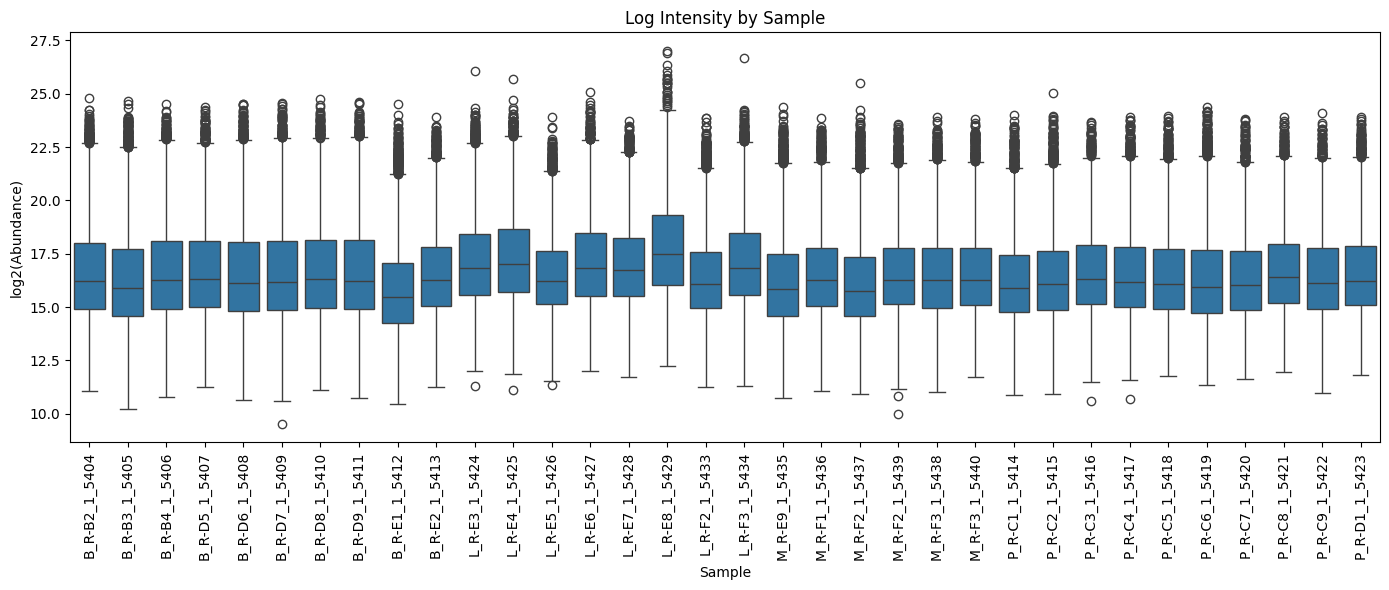

In [3]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=merged_df, x='Sample', y='logIntensity')
plt.xticks(rotation=90)
plt.ylabel('log2(Abundance)')
plt.title('Log Intensity by Sample')
plt.tight_layout()
plt.show()

The QCplots show some pretty significant variance across runs for a DIA 
experiment. We could probably reprocess with some stronger normalization at the 
fragment-level to remove some technical noise in our analysis.



## Run differential analysis

In [4]:
from scipy.stats import t

def fit_one_protein(df):

    """
    Fit a linear model for a single protein's abundance across conditions. 
    Assumes df contains protein-level data in long format with columns:
    - 'Protein': protein identifier (should be the same for all rows)
    - 'Condition': categorical variable indicating experimental condition
    - 'logIntensity': log2-transformed abundance values

    This function performs pairwise comparisons of conditions using an 
    ordinary least squares (OLS) regression model. It computes the log2 
    fold change, t-statistic, standard error, degrees of freedom, and 
    two-sided p-value for each pairwise condition comparison.

    Parameters
    ----------
    df : pandas.DataFrame
        A long-format DataFrame containing columns:
        - 'Protein': protein identifier (should be the same for all rows)
        - 'Condition': categorical variable indicating experimental condition
        - 'logIntensity': log2-transformed abundance values

    Returns
    -------
    results_df : pandas.DataFrame
        DataFrame with one row per pairwise condition comparison, containing:
        - 'Protein': protein identifier
        - 'comparison': string label for the comparison (e.g., 'A-B')
        - 'logFC': log2 fold change between conditions
        - 't_stat': t-statistic for the comparison
        - 'std_error': standard error of the difference
        - 'df': degrees of freedom for the test
        - 'p_value': two-sided p-value for the difference

    Notes
    -----
    - The function removes conditions where all logIntensity values are missing.
    - Uses ordinary least squares (OLS) regression with statsmodels.
    - All pairwise differences between conditions are computed.
    - The reference condition is the first observed in the data.
    """

    # Remove conditions if all data missing
    df = df[df.groupby('Condition')['logIntensity'].transform(lambda x: x.notna().any())]
    
    sm_model = sm.OLS.from_formula('logIntensity ~ Condition', data=df)
    res = sm_model.fit()
    
    params = res.params.copy()
    # Rename 'Intercept' to the reference (dropped) condition
    reference_condition = df['Condition'].unique()[0]
    params[reference_condition] = params.pop('Intercept')
    params[reference_condition] = 0

    params.index = [c.replace('Condition[T.', '').replace(']', '') for c in params.index]
    
    # Replace 'Intercept' with the reference condition in the covariance matrix as well
    cov = res.cov_params()
    reference_condition = df['Condition'].unique()[0]
    if 'Intercept' in cov.index:
        cov = cov.rename(index={'Intercept': reference_condition}, columns={'Intercept': reference_condition})
    cov.index = [c.replace('Condition[T.', '').replace(']', '') for c in cov.index]
    cov.columns = [c.replace('Condition[T.', '').replace(']', '') for c in cov.columns]

    # Calculate all pairwise differences between conditions
    diffs = {}
    covs = {}
    for cond1, cond2 in combinations(params.index, 2):
        # Ensure the comparison label is always in alphabetical order
        conds = sorted([cond1, cond2])
        diff_label = f"{conds[0]}-{conds[1]}"
        diffs[diff_label] = params[conds[0]] - params[conds[1]]
        
        covs[diff_label] = np.sqrt(cov.loc[cond1, cond1] + cov.loc[cond2, cond2] - 2 * cov.loc[cond1, cond2])
    
    
    t_stat = {k: diffs[k] / covs[k] for k in diffs}
    
    dfree = res.df_resid
    p_values = {k: 2 * t.sf(abs(v), dfree) for k, v in t_stat.items()}
    
    results_df = pd.DataFrame({
        'Protein': df['Protein'].iloc[0],
        'comparison': list(t_stat.keys()),
        'logFC': list(diffs.values()),
        't_stat': list(t_stat.values()),
        'std_error': list(covs.values()),
        'df': dfree,
        'p_value': [p_values[k] for k in t_stat.keys()],
    })
    
    return results_df

In [5]:
import warnings
from tqdm.notebook import tqdm

all_proteins = merged_df["Protein"].unique()
results = []
for prot in tqdm(all_proteins, desc="Fitting proteins"):
    df_prot = merged_df[merged_df["Protein"] == prot]
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            res_df = fit_one_protein(df_prot)
        results.append(res_df)
    except Exception:
        continue
all_results_df = pd.concat(results, ignore_index=True)

Fitting proteins:   0%|          | 0/10876 [00:00<?, ?it/s]

In [6]:
# Adjust p-values for each comparison group using Benjamini-Hochberg (FDR)
for comp, group in all_results_df.groupby('comparison'):
    # Only adjust if there are non-null p-values
    mask = group['p_value'].notnull()
    if mask.sum() > 0:
        reject, pvals_corrected, _, _ = multipletests(group.loc[mask, 'p_value'], method='fdr_bh')
        all_results_df.loc[group.loc[mask].index, 'p_adj'] = pvals_corrected


In [14]:
len(all_results_df[all_results_df["p_adj"] < 0.05]) / len(all_results_df)

0.316129889691224

We see about ~1/3rd of the comparisons as differentially abundant with 
$\alpha<.05$. This indicates that there are definitely some changes between 
tissue types across all proteins in the data. We need these differences in 
order to perform our complex analysis

## Compare to CORUM complex db

We are going to look for complexes which appear to be composed of different 
sets of proteins depending on tissue type. We can do this by looking at both 
protein abundances and half lifes. Ideally, if there different forms of a 
complex, we should be able to identify which form we are currently looking at.

### Prepare data for complex analysis

In [ ]:
corum_db = pd.read_csv('../data/corum_allComplexes.txt', sep="\t")
corum_complex_genes = corum_db.set_index('complex_name')['subunits_gene_name'].str.split(';').to_dict()

# Convert uniprot names to HGNC names for corum complex genes
all_results_df['Protein'] = all_results_df['Protein'].apply(
    lambda x: uniprot_to_hgnc_name(x))
merged_df['Protein'] = merged_df['Protein'].apply(
    lambda x: uniprot_to_hgnc_name(x))

### Get an idea of which complexes we can analyze

In order to even do this comparison we need to find complexes which have:
- all proteins measured (or at least majority of protein measured)
- differentially abundant proteins (i.e., some proteins in the complex are 
    changing across tissue types)

In [ ]:
from tqdm.notebook import tqdm

observed_percentages = {}
diff_abundant_percentages = {}

# Set of all observed proteins (after mapping to HGNC names)
observed_genes = set(all_results_df['Protein'].dropna().unique())
# Set of all differentially abundant proteins (adj p < 0.05)
diff_abundant_genes = set(all_results_df.loc[all_results_df['p_adj'] < 0.05, 'Protein'].dropna().unique())

for complex_name, gene_list in tqdm(corum_complex_genes.items(), 
                                    desc="Processing complexes"):
    # Remove empty strings and strip whitespace
    genes = [g.strip() for g in gene_list if g.strip()]
    if not genes:
        continue
    n_total = len(genes)
    n_observed = sum(g in observed_genes for g in genes)
    n_diff_abundant = sum(g in diff_abundant_genes for g in genes)
    observed_percentages[complex_name] = n_observed / n_total
    diff_abundant_percentages[complex_name] = n_diff_abundant / n_total

print(f"Mean percentage of observed genes per complex: {np.mean(list(observed_percentages.values())):.2%}")
print(f"Mean percentage of differentially abundant genes per complex: {np.mean(list(diff_abundant_percentages.values())):.2%}")

Processing complexes:   0%|          | 0/7603 [00:00<?, ?it/s]

Mean percentage of observed genes per complex: 16.13%
Mean percentage of differentially abundant genes per complex: 10.86%


In [17]:
import random

observed_nonzero = {k: v for k, v in observed_percentages.items() if v > 0}
# Print a few sampled key-value pairs from the dictionary
sample_keys = random.sample(list(observed_nonzero.keys()), 3)
for k in sample_keys:
    print(f"{k}: {observed_nonzero[k]}")

Nod2-Ripk2 complex: 0.5
Crtap-P3h1-Ppib complex: 1.0
Slc6a1-Stx1a complex: 1.0


### Ahr-Arnt complex

In [21]:
print(corum_complex_genes['Ahr-Arnt complex'])
print(f"Percentage observed: {observed_percentages['Ahr-Arnt complex']}")
print(f"Percentage differentially abundant: {diff_abundant_percentages['Ahr-Arnt complex']}")

['Ahr', 'Arnt']
Percentage observed: 1.0
Percentage differentially abundant: 1.0


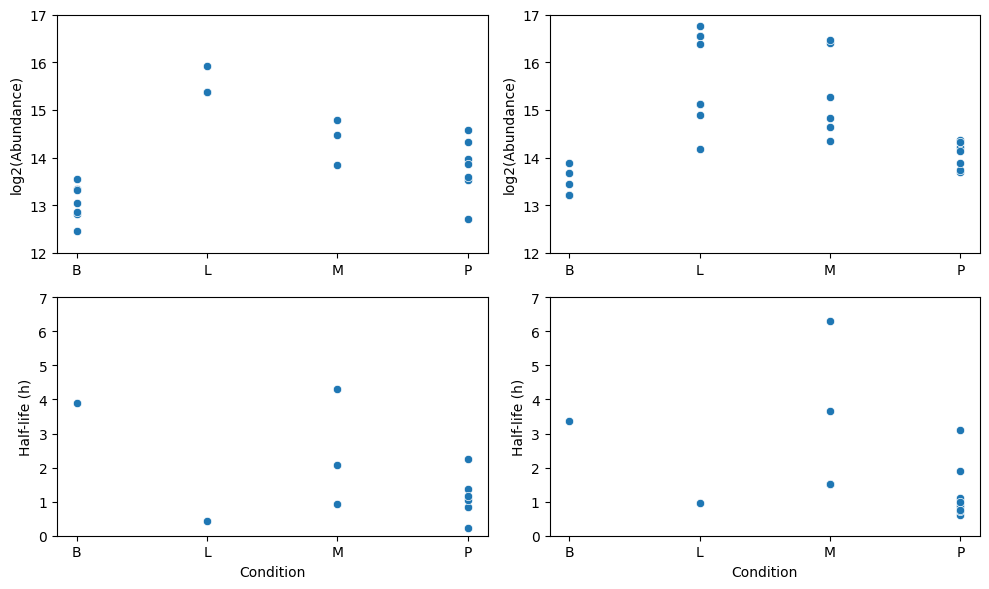

In [22]:
plot_df1 = merged_df[merged_df["Protein"] == "Ahr"]
plot_df2 = merged_df[merged_df["Protein"] == "Arnt"]

fig, ax = plt.subplots(2,2,figsize=(10, 6))
sns.scatterplot(data=plot_df1, x='Condition', y='logIntensity', ax=ax[0,0])
sns.scatterplot(data=plot_df2, x='Condition', y='logIntensity', ax=ax[0,1])
sns.scatterplot(data=plot_df1, x='Condition', y='Half_life', ax=ax[1,0])
sns.scatterplot(data=plot_df2, x='Condition', y='Half_life', ax=ax[1,1])

# set same y-axis limits for logIntensity and Half_life
# Set consistent y-axis limits for better comparison
ax[0,0].set_ylim(12, 17)
ax[0,1].set_ylim(12, 17)
ax[1,0].set_ylim(0, 7)
ax[1,1].set_ylim(0, 7)

# Improve axis labels and layout
ax[0,0].set_ylabel('log2(Abundance)')
ax[0,1].set_ylabel('log2(Abundance)')
ax[1,0].set_ylabel('Half-life (h)')
ax[1,1].set_ylabel('Half-life (h)')
ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[1,0].set_xlabel('Condition')
ax[1,1].set_xlabel('Condition')

plt.tight_layout()


Seems like for this complex they may be bound in Liver but not in Brain? M and P
are also questionable.

### Aqp4-Dag1-Dmd-Snta1 complex

In [24]:
print(corum_complex_genes['Aqp4-Dag1-Dmd-Snta1 complex'])
print(f"Percentage observed: {observed_percentages['Aqp4-Dag1-Dmd-Snta1 complex']}")
print(f"Percentage differentially abundant: {diff_abundant_percentages['Aqp4-Dag1-Dmd-Snta1 complex']}")

['Aqp4', 'Dag1', 'Dmd', 'Snta1']
Percentage observed: 1.0
Percentage differentially abundant: 1.0


Text(0.5, 1.0, 'Snta1')

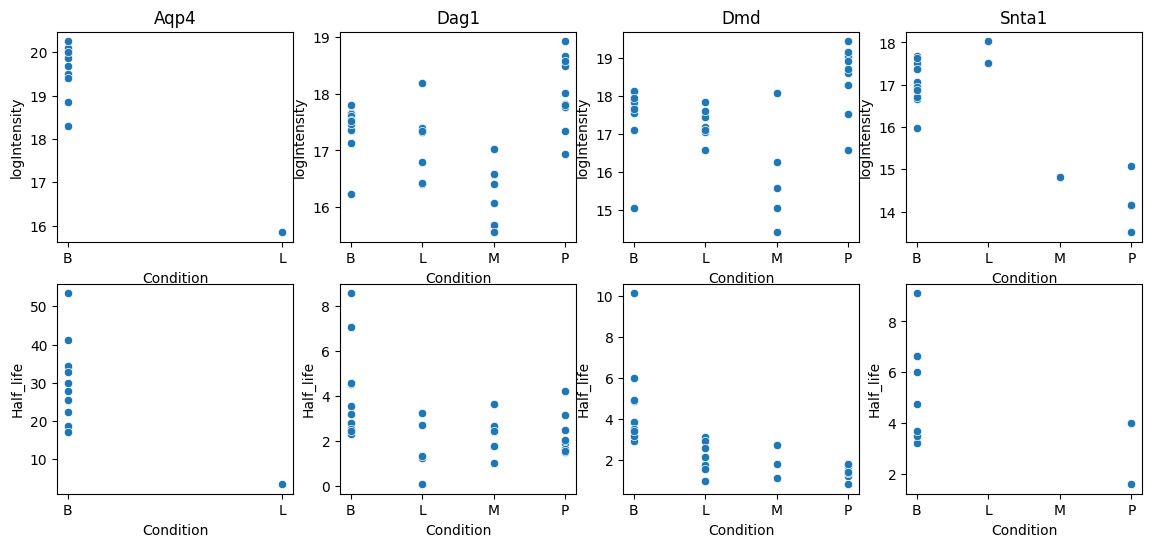

In [25]:
plot_df1 = merged_df[merged_df["Protein"] == corum_complex_genes['Aqp4-Dag1-Dmd-Snta1 complex'][0]]
plot_df2 = merged_df[merged_df["Protein"] == corum_complex_genes['Aqp4-Dag1-Dmd-Snta1 complex'][1]]
plot_df3 = merged_df[merged_df["Protein"] == corum_complex_genes['Aqp4-Dag1-Dmd-Snta1 complex'][2]]
plot_df4 = merged_df[merged_df["Protein"] == corum_complex_genes['Aqp4-Dag1-Dmd-Snta1 complex'][3]]

fig, ax = plt.subplots(2,4,figsize=(14, 6))
sns.scatterplot(data=plot_df1, x='Condition', y='logIntensity', ax=ax[0,0])
sns.scatterplot(data=plot_df2, x='Condition', y='logIntensity', ax=ax[0,1])
sns.scatterplot(data=plot_df3, x='Condition', y='logIntensity', ax=ax[0,2])
sns.scatterplot(data=plot_df4, x='Condition', y='logIntensity', ax=ax[0,3])

sns.scatterplot(data=plot_df1, x='Condition', y='Half_life', ax=ax[1,0])
sns.scatterplot(data=plot_df2, x='Condition', y='Half_life', ax=ax[1,1])
sns.scatterplot(data=plot_df3, x='Condition', y='Half_life', ax=ax[1,2])
sns.scatterplot(data=plot_df4, x='Condition', y='Half_life', ax=ax[1,3])

# set same y-axis limits for logIntensity and Half_life
# ax[0,0].set_ylim(12,17)
# ax[0,1].set_ylim(12,17)
# ax[1,0].set_ylim(0,7)
# ax[1,1].set_ylim(0,7)

ax[0,0].set_title(corum_complex_genes['Aqp4-Dag1-Dmd-Snta1 complex'][0])
ax[0,1].set_title(corum_complex_genes['Aqp4-Dag1-Dmd-Snta1 complex'][1])
ax[0,2].set_title(corum_complex_genes['Aqp4-Dag1-Dmd-Snta1 complex'][2])
ax[0,3].set_title(corum_complex_genes['Aqp4-Dag1-Dmd-Snta1 complex'][3])

## Multiform complexes

### Find complexes with multiple forms

In [41]:
complex_variations = dict()

full_observed_complexes = [k for k, v in observed_percentages.items() if v == 1]
loop_full_complexes = {k: corum_complex_genes[k] for k in full_observed_complexes}

for complex_name, gene_list in tqdm(loop_full_complexes.items(), 
                                    desc="Finding almost complete complexes"):
    variation_list_temp = list()
    
    for compare_complex_name, compare_gene_list in loop_full_complexes.items():
        # Skip self-comparison
        if complex_name == compare_complex_name:
            continue
        
        if len(np.intersect1d(gene_list, compare_gene_list)) / len(gene_list) > 0.5:
            variation_list_temp.append(compare_complex_name)
    
    if len(variation_list_temp) > 0:
        complex_variations[complex_name] = variation_list_temp

Finding almost complete complexes:   0%|          | 0/704 [00:00<?, ?it/s]

In [47]:

# Move keys into values list for complex_variations
complex_variations_with_keys = {k: [k] + v for k, v in complex_variations.items()}
# Convert to list of lists, removing the key
complex_variations_list = list(complex_variations_with_keys.values())
# Remove duplicate sets (complexes with same members in different order)
unique_variations = []
for v in complex_variations_list:
    v_set = set(v)
    if not any(v_set == set(u) for u in unique_variations):
        unique_variations.append(v)
len(unique_variations)

201

There are still some duplicates in this list but it's kinda hard to remove them.

#### APBA1 - CASK - LIN7A

LIN7A can drop out of the complex. There are other forms of this complex as well, 
but we can just look at these three to start.

In [57]:
loop_full_complexes[unique_variations[1][0]]

['Apba1', 'Cask', 'Lin7a']

In [ ]:
loop_full_complexes[unique_varimations[1][1]]

['Apba1', 'Cask']

Text(0.5, 1.0, 'Lin7a')

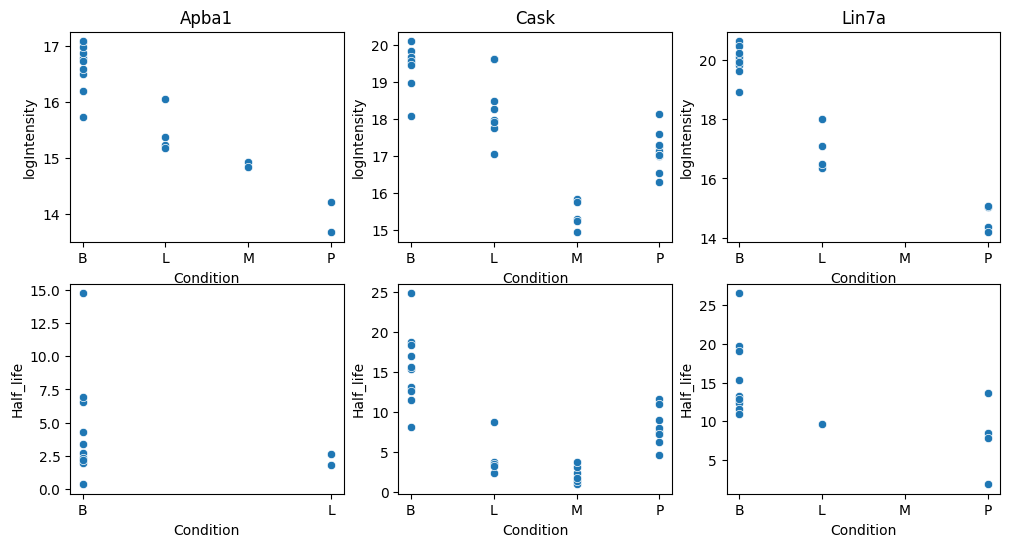

In [59]:
plot_df1 = merged_df[merged_df["Protein"] == loop_full_complexes[unique_variations[1][0]][0]]
plot_df2 = merged_df[merged_df["Protein"] == loop_full_complexes[unique_variations[1][0]][1]]
plot_df3 = merged_df[merged_df["Protein"] == loop_full_complexes[unique_variations[1][0]][2]]

fig, ax = plt.subplots(2,3,figsize=(12, 6))
sns.scatterplot(data=plot_df1, x='Condition', y='logIntensity', ax=ax[0,0])
sns.scatterplot(data=plot_df2, x='Condition', y='logIntensity', ax=ax[0,1])
sns.scatterplot(data=plot_df3, x='Condition', y='logIntensity', ax=ax[0,2])

sns.scatterplot(data=plot_df1, x='Condition', y='Half_life', ax=ax[1,0])
sns.scatterplot(data=plot_df2, x='Condition', y='Half_life', ax=ax[1,1])
sns.scatterplot(data=plot_df3, x='Condition', y='Half_life', ax=ax[1,2])

# set same y-axis limits for logIntensity and Half_life
# ax[0,0].set_ylim(12,17)
# ax[0,1].set_ylim(12,17)
# ax[1,0].set_ylim(0,7)
# ax[1,1].set_ylim(0,7)

ax[0,0].set_title(loop_full_complexes[unique_variations[1][0]][0])
ax[0,1].set_title(loop_full_complexes[unique_variations[1][0]][1])
ax[0,2].set_title(loop_full_complexes[unique_variations[1][0]][2])

Doesn't look like much we can distinguish here. Maybe the entire complex is 
disconnected in M.

We need to loop over more of these but vizually inspecting them doesn't really 
work well across many examples. Next step is to design an algorithm to check 
this based on differential abundance changes.